In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph, plot_elbo
from libs.model import HGPforecaster, PiecewiseLinearChangepoints
import numpy as np
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

import theano
theano.config.compute_test_value='raise'

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')
dates_ = prison['t'].astype('datetime64[ns]')

In [4]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [5]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [6]:
groups = generate_groups_data_flat(y = prison_pivot, 
                               groups_input = groups_input, 
                               seasonality=4, 
                               h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [7]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  likelihood='normal',
                  changepoints=4,
                  minibatch=[20, 10])

In [8]:
#m.prior_predictive_checks()
#visualize_prior(groups, m.prior_checks, 8)

In [9]:
m.fit_vi()

Fitting model...


Interrupted at 1,007 [1%]: Average Loss = 5.866e+05


Sampling...


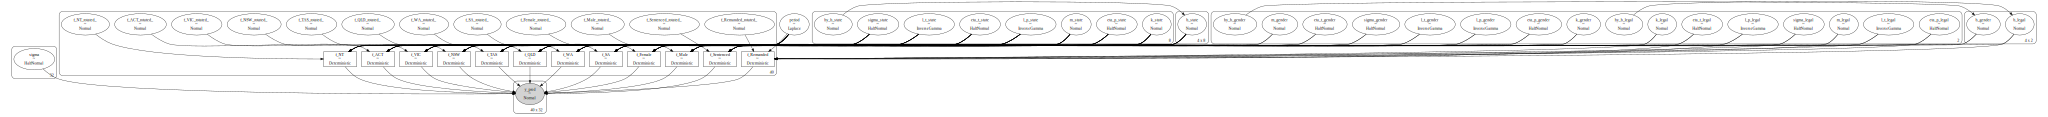

In [10]:
model_graph(m.model)

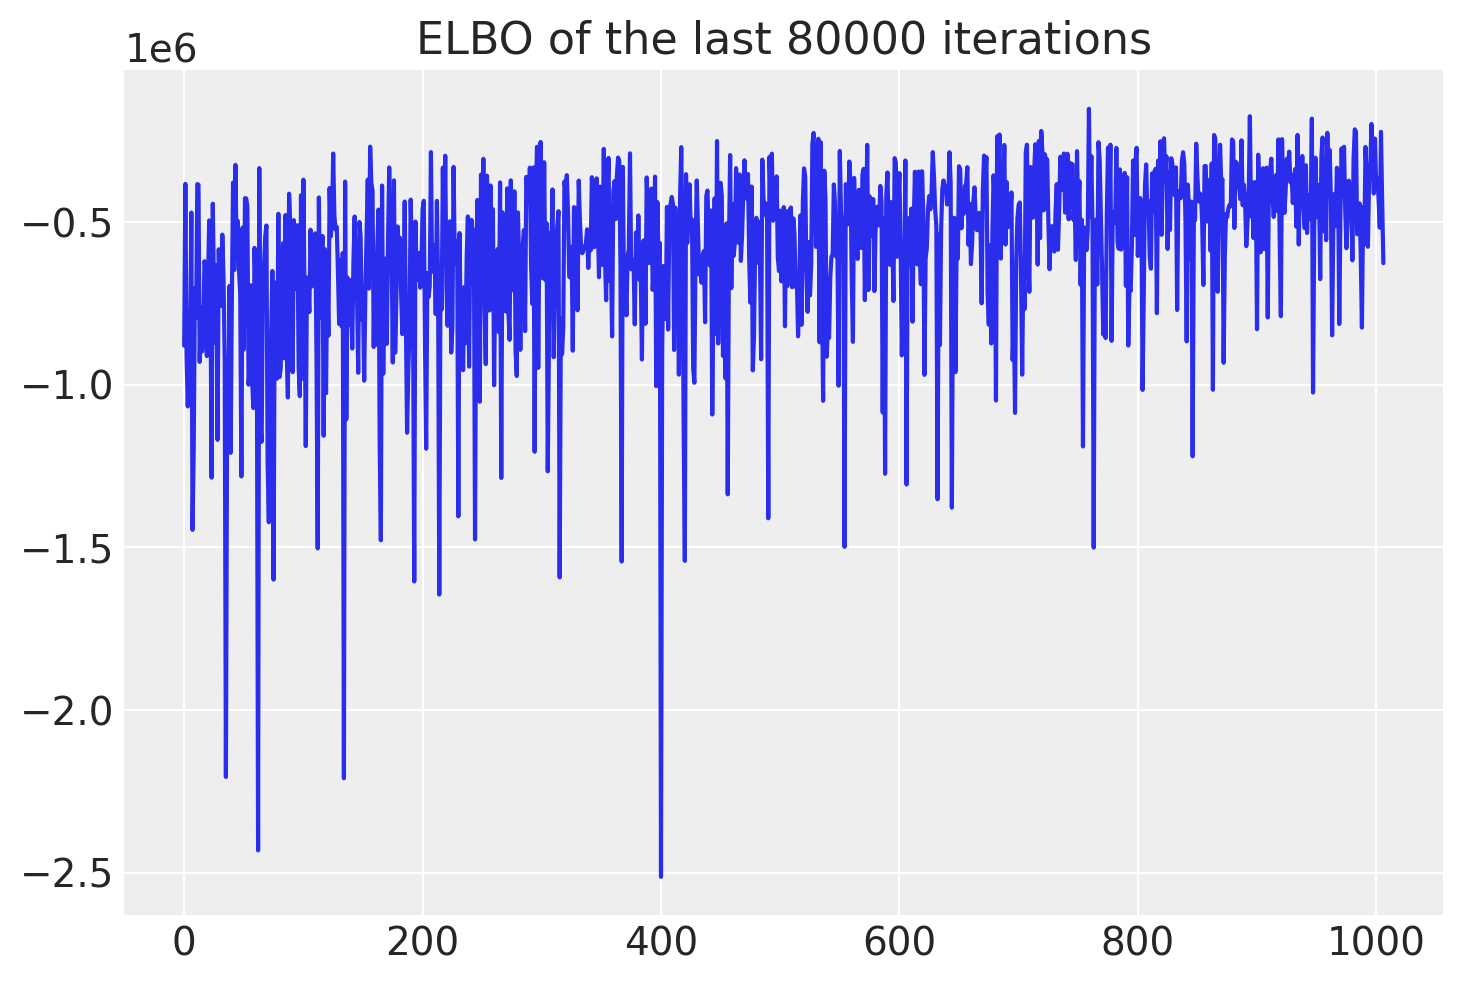

In [11]:
plot_elbo(m.trace_vi)

In [12]:
m.predict()

Sampling...


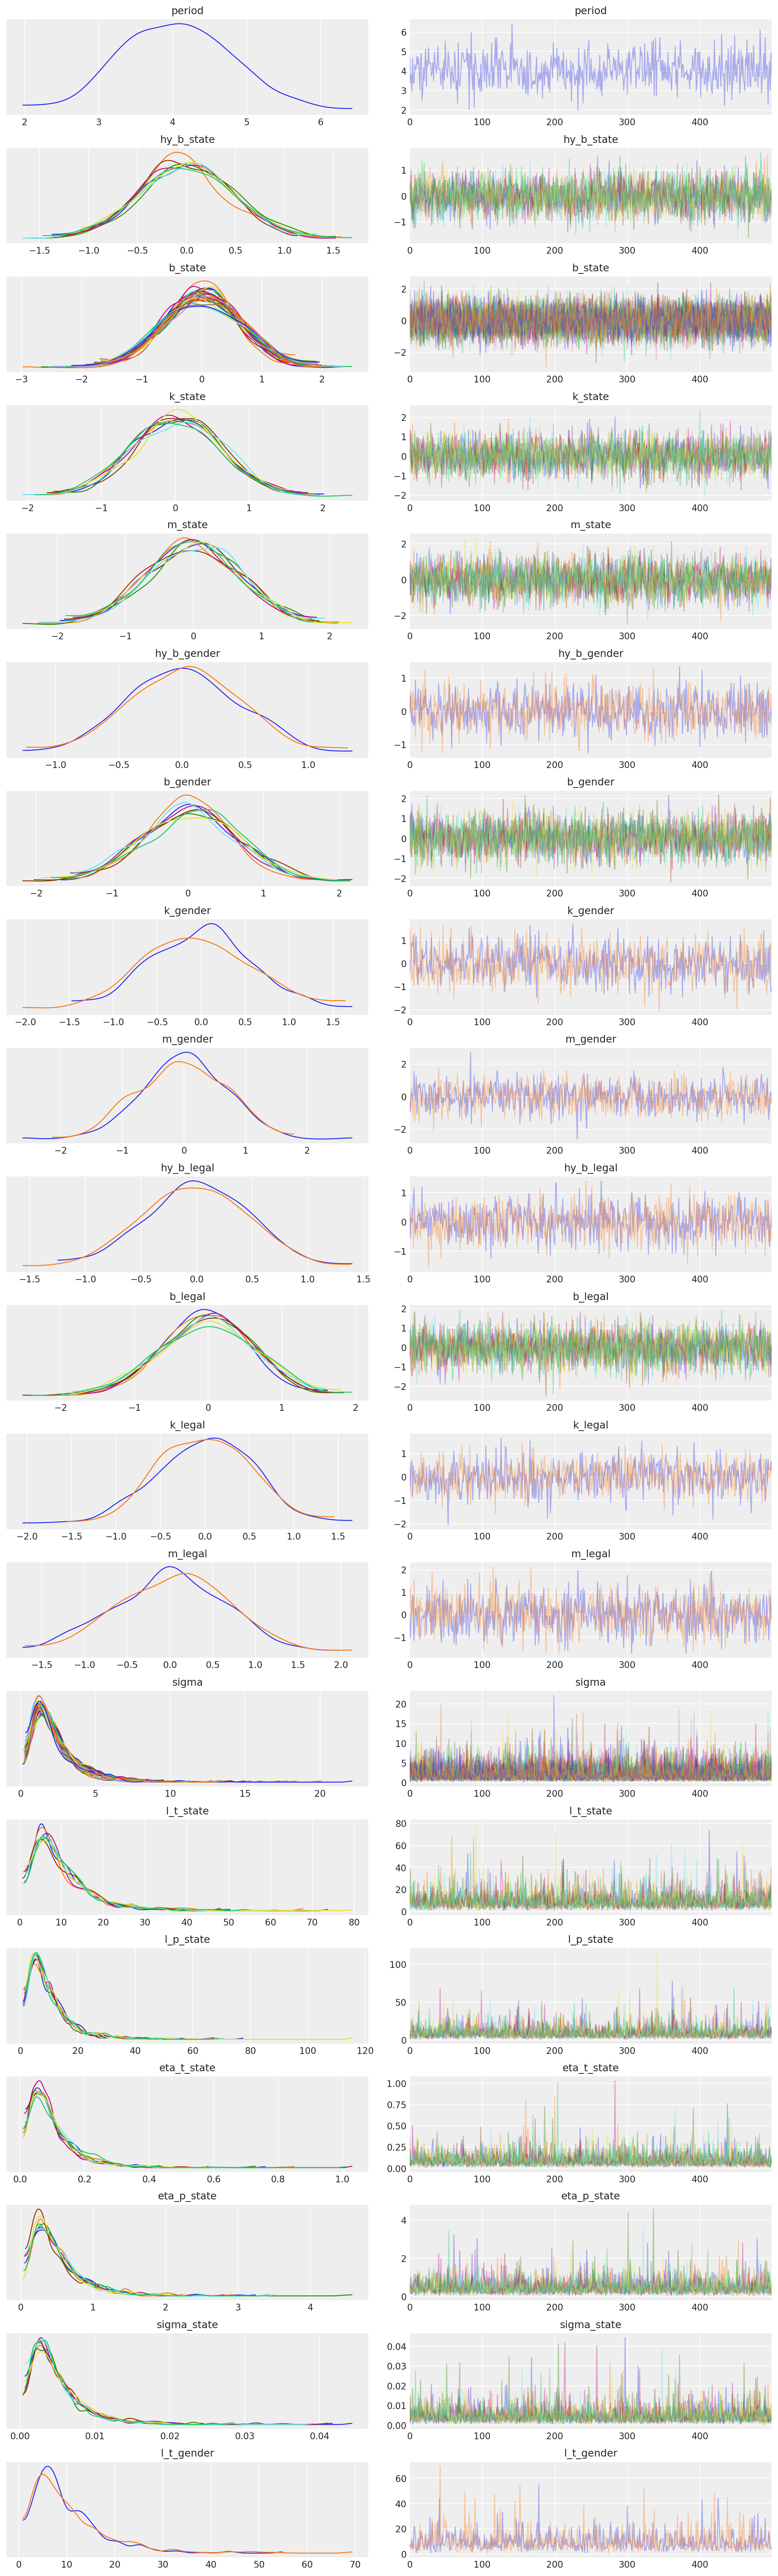

In [13]:
traceplot(m.trace_vi_samples);

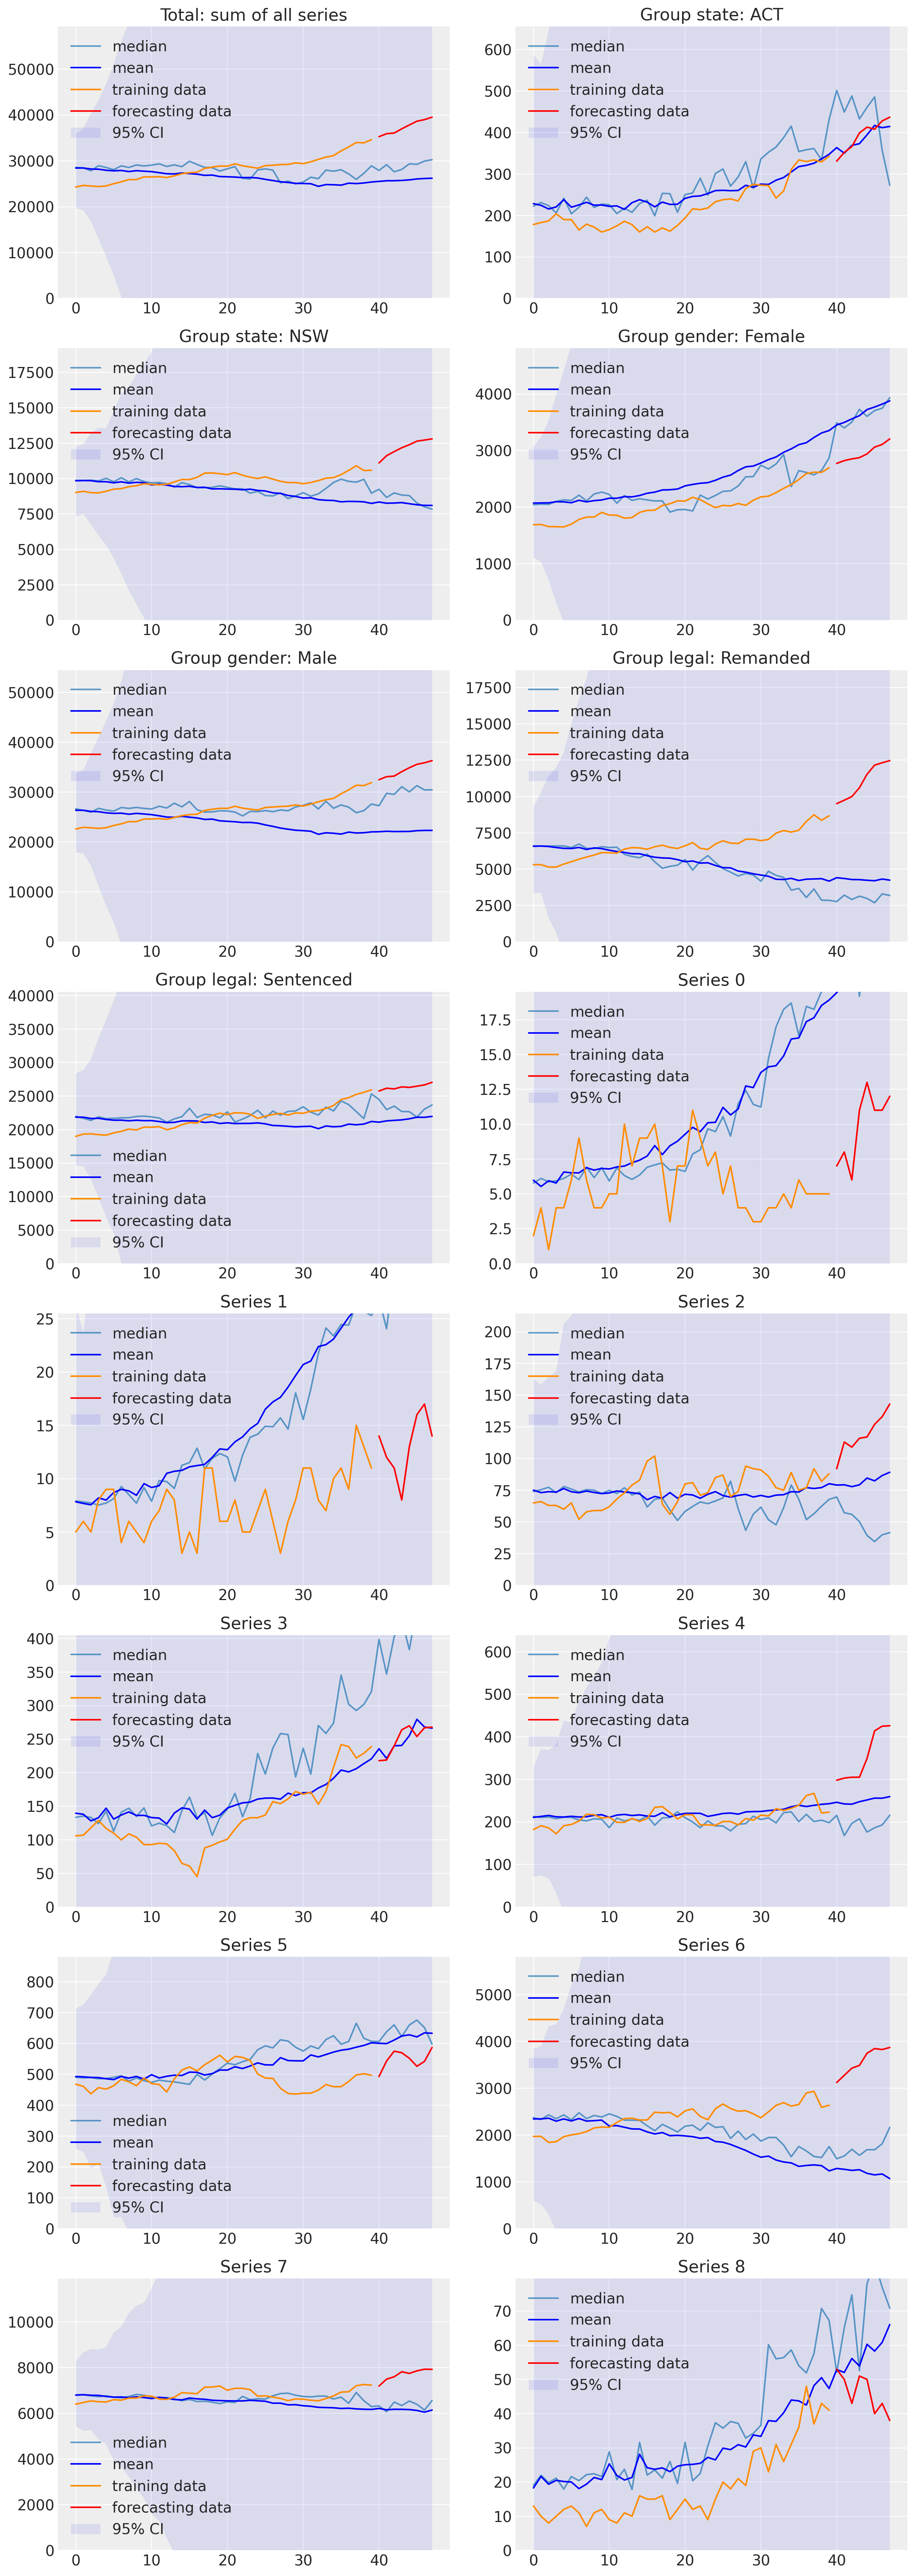

In [14]:
visualize_predict(groups, m.pred_samples_predict, 10)

In [15]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)